# 0. Data Pre-Processing and EDA

Overview:
- This notebook will perform image pre-processing and EDA to ensure standard inputs to the eventual machine learning classifiers
- The process will include the following:
    - Size and Channels standardization
    - Normalization of all images
    - Ensuring all images are of the same data-type

### 0. Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv

### 1. Load all images, plot shape distribution, and show example images

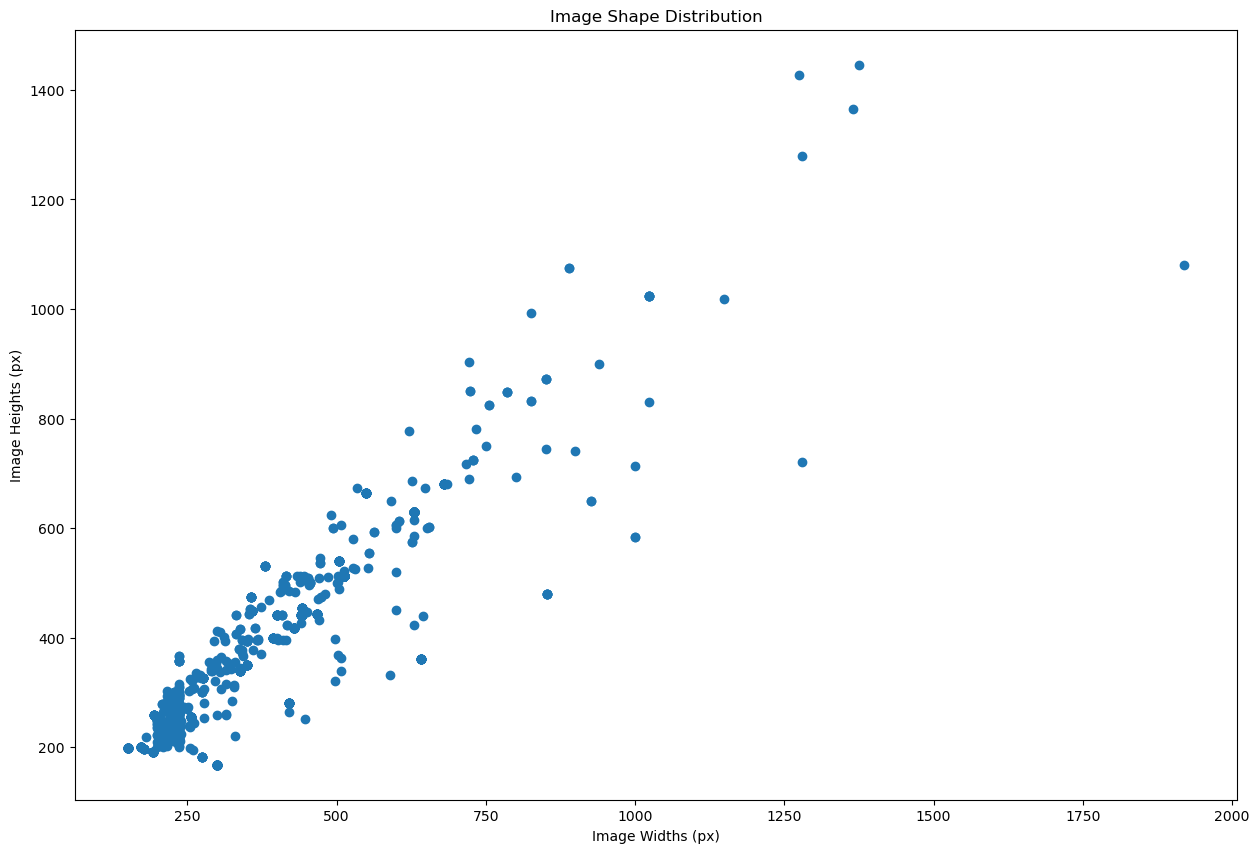

/tmp/ipykernel_3187/970947532.py:62: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,5,column_indexer+counter+1)


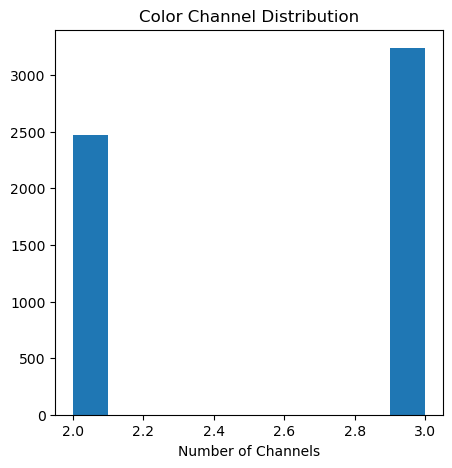

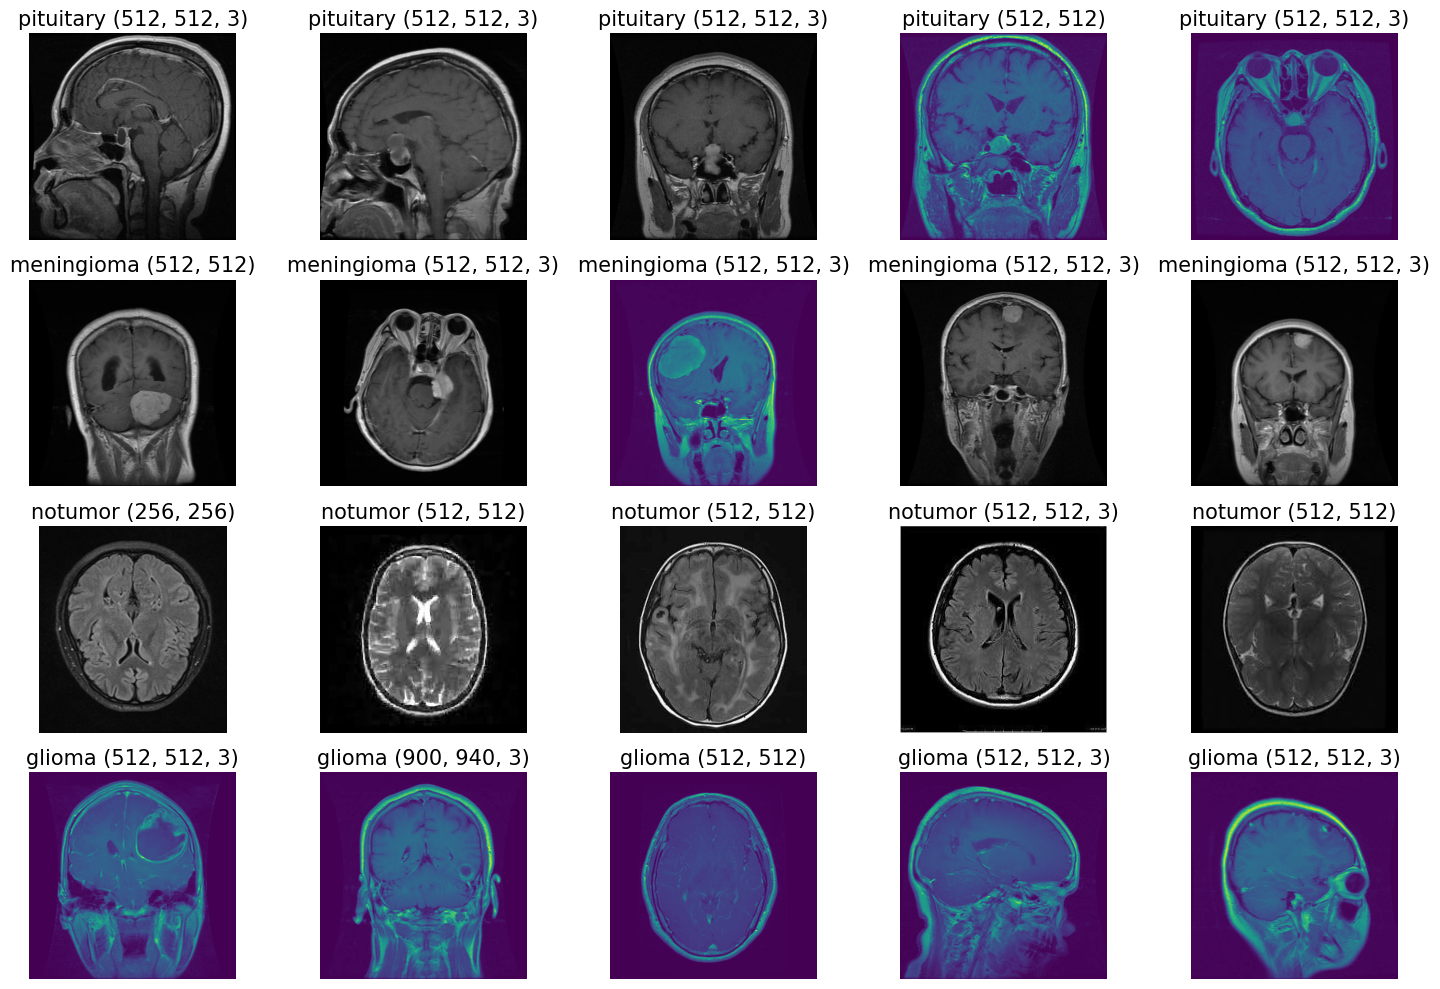

In [2]:
# Setup Data Paths
cwd = os.getcwd()
data_path = os.path.join(cwd,'data')
training_path = os.path.join(data_path,'Training')

# Initialize Data Variables
X_train = []
Y_train = []
img_shapes = []
label_names = []

# Load in Images and Labels
for label in os.listdir(training_path):
    label_names.append(label)
    label_path = os.path.join(training_path,label)
    for image in os.listdir(label_path):
        image_path = os.path.join(label_path,image)
        img_array = plt.imread(image_path)
        # img_array = cv.imread(image_path)

        # # Turn all Images to Gray Scale
        # img_array = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)
        img_shapes.append(img_array.shape)
        X_train.append(img_array)
        Y_train.append(label)

# Shuffle Data for Randomization
np.random.seed(281)
indices = [i for i in range(0,len(X_train))]
shuffle_indices = np.random.permutation(indices)
X_train_shuffled = [X_train[i] for i in shuffle_indices]
Y_train_shuffled = [Y_train[i] for i in shuffle_indices]


# Plot Distribution of Image Shapes
img_shape_widths = [img[1] for img in img_shapes]
img_shape_heights = [img[0] for img in img_shapes]
plt.figure(figsize=(15,10))
plt.scatter(img_shape_widths, img_shape_heights)
plt.title("Image Shape Distribution")
plt.xlabel("Image Widths (px)")
plt.ylabel("Image Heights (px)")
plt.show()

# Channel Distribution
channel_size = [len(shape) for shape in img_shapes]
plt.figure(figsize = (5,5))
plt.hist(channel_size)
plt.title("Color Channel Distribution")
plt.xlabel("Number of Channels")


# Plot Example Images of Each Label
plt.figure(figsize = (15,10))
plt.axis('off')
column_indexer = 0
while column_indexer < 20:
    for label in label_names:
        index_pos = [i for i, x in enumerate(Y_train_shuffled) if x == label]
        for counter in range(0,5):
            image_index_value = index_pos[counter]
            plt.subplot(4,5,column_indexer+counter+1)
            plt.title(label +' ' + str(img_shapes[image_index_value]), fontsize=15)
            plt.axis('off')
            plt.imshow(X_train_shuffled[image_index_value])
        column_indexer = column_indexer + 5
plt.tight_layout()
plt.show()


### 2. Resolution/sizing Standardization

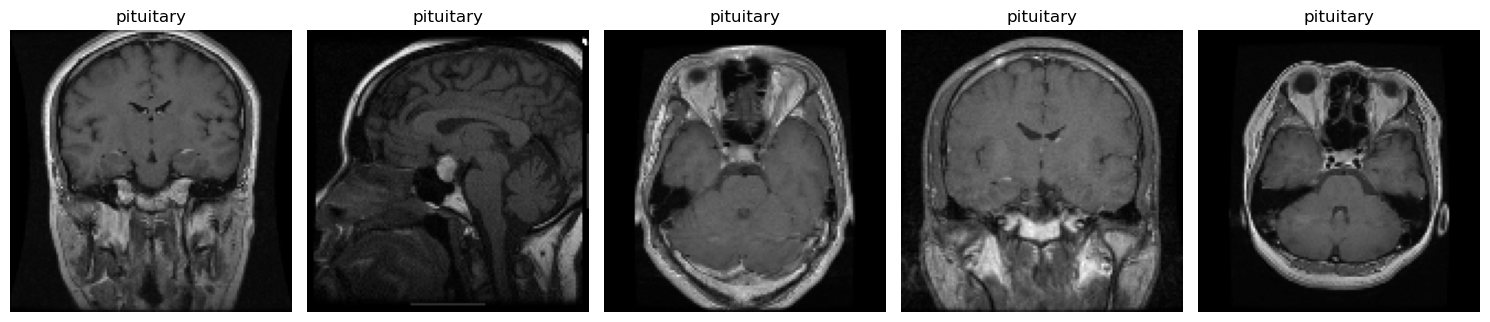

In [27]:
# Set image size
TARGET_SIZE = (128, 128)

# Resize while preserving aspect ratio and pad to fixed size
def resize_with_padding(img, target_size=(128, 128)):
    old_h, old_w = img.shape
    target_h, target_w = target_size

    # Scale image while keeping aspect ratio
    scale = min(target_w / old_w, target_h / old_h)
    new_w, new_h = int(old_w * scale), int(old_h * scale)
    resized_img = cv.resize(img, (new_w, new_h))

    # Calculate padding
    top = (target_h - new_h) // 2
    bottom = target_h - new_h - top
    left = (target_w - new_w) // 2
    right = target_w - new_w - left

    # Add border to make it the target size
    padded_img = cv.copyMakeBorder(resized_img, top, bottom, left, right,
                                   borderType=cv.BORDER_CONSTANT, value=0)
    return padded_img

# Initialize storage
X_train = []
Y_train = []
img_shapes = []
label_names = []

# Load grayscale, resized, and padded images
for label in os.listdir(training_path):
    label_names.append(label)
    label_path = os.path.join(training_path, label)
    for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # Load as grayscale
        img_array = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        if img_array is None:
            continue 

        # Resize with padding
        img_array = resize_with_padding(img_array, TARGET_SIZE)

        # Normalize
        img_array = img_array / 255.0

        img_shapes.append(img_array.shape)
        X_train.append(img_array)
        Y_train.append(label)

# Convert to arrays
X_train = np.array(X_train)[..., np.newaxis]
Y_train = np.array(Y_train)

# Preview
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(Y_train[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Sample Preview Testing

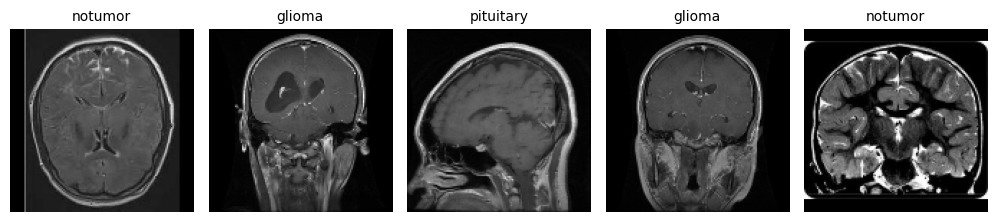

In [28]:
import random
plt.figure(figsize=(20, 5)) 
random_indices = random.sample(range(len(X_train)), 5)
for i, idx in enumerate(random_indices):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[idx].squeeze(), cmap='gray')
    plt.title(Y_train[idx], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()



EDA

In [ ]:
print("Total images:", len(X_train))
print("Image shape (single sample):", X_train[0].shape)
print("Total labels:", len(Y_train))

Total images: 5712
Image shape (single sample): (128, 128, 1)
Total labels: 5712


In [30]:
unique_shapes = set([x.shape for x in X_train])
print("Unique image shapes:", unique_shapes)

Unique image shapes: {(128, 128, 1)}


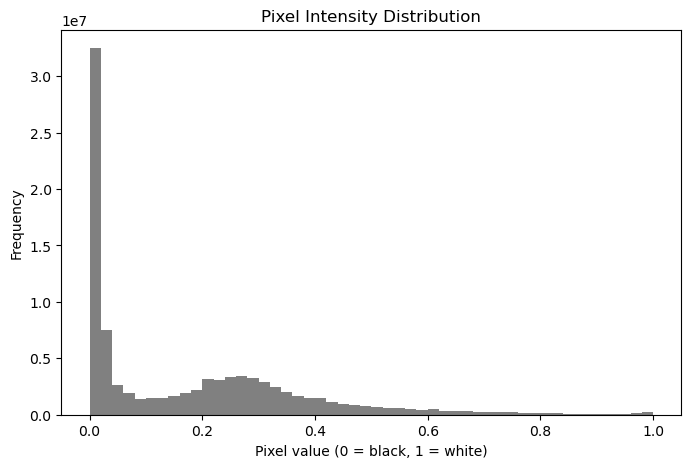

In [31]:
plt.figure(figsize=(8, 5))
plt.hist(X_train.flatten(), bins=50, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel value (0 = black, 1 = white)")
plt.ylabel("Frequency")
plt.show()


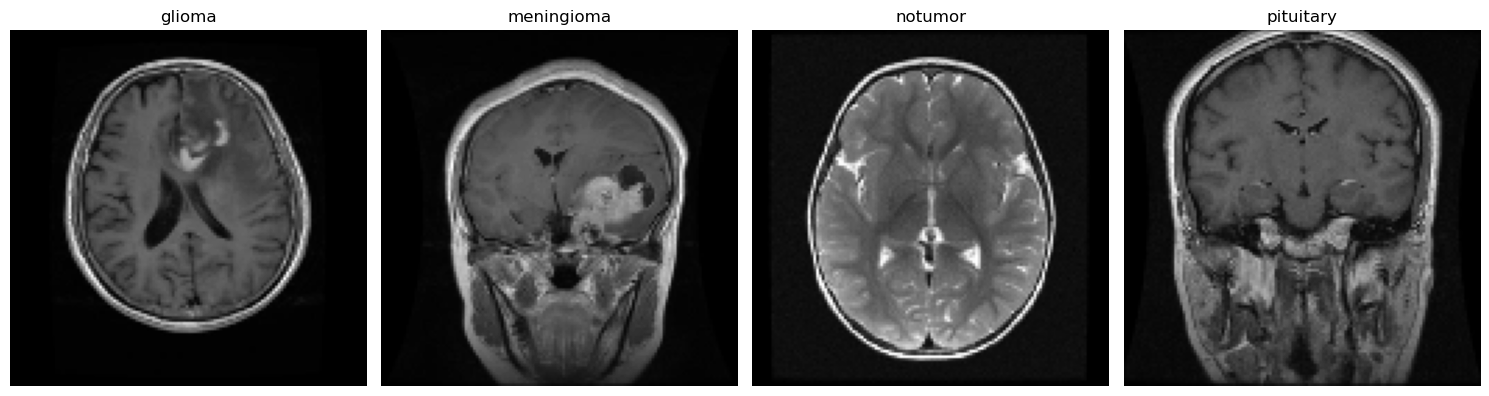

In [35]:
plt.figure(figsize=(15, 10))

for i, label in enumerate(np.unique(Y_train)):
    idx = np.where(Y_train == label)[0][0]  # first image of this label
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train[idx].squeeze(), cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [36]:
X_flat = X_train.reshape(len(X_train), -1)
print("Per-image mean pixel value:", np.mean(X_flat, axis=1)[:5])
print("Overall mean pixel value:", np.mean(X_flat))
print("Overall std deviation:", np.std(X_flat))


Per-image mean pixel value: [0.21358499 0.14505496 0.17606249 0.24128538 0.14662248]
Overall mean pixel value: 0.17788243482590438
Overall std deviation: 0.19873243458202547


In [ ]:
import pandas as pd
import seaborn as sns

# Prepare a list of average brightness values per image
brightness_data = []

# Average pixel value of image
for i in range(len(X_train)):
    brightness = np.mean(X_train[i])  
    label = Y_train[i]
    brightness_data.append((label, brightness))

# Convert to DataFrame
df_brightness = pd.DataFrame(brightness_data, columns=["Label", "Avg_Brightness"])

# Summary statistics
print(df_brightness.groupby("Label")["Avg_Brightness"].describe())


             count      mean       std       min       25%       50%  \
Label                                                                  
glioma      1321.0  0.128618  0.033662  0.053885  0.102269  0.124157   
meningioma  1339.0  0.167534  0.048656  0.071692  0.136840  0.160421   
notumor     1595.0  0.213044  0.073718  0.021477  0.157467  0.211573   
pituitary   1457.0  0.193567  0.032116  0.097026  0.173211  0.195604   

                 75%       max  
Label                           
glioma      0.151830  0.268696  
meningioma  0.183051  0.539810  
notumor     0.252397  0.447792  
pituitary   0.213203  0.396154  


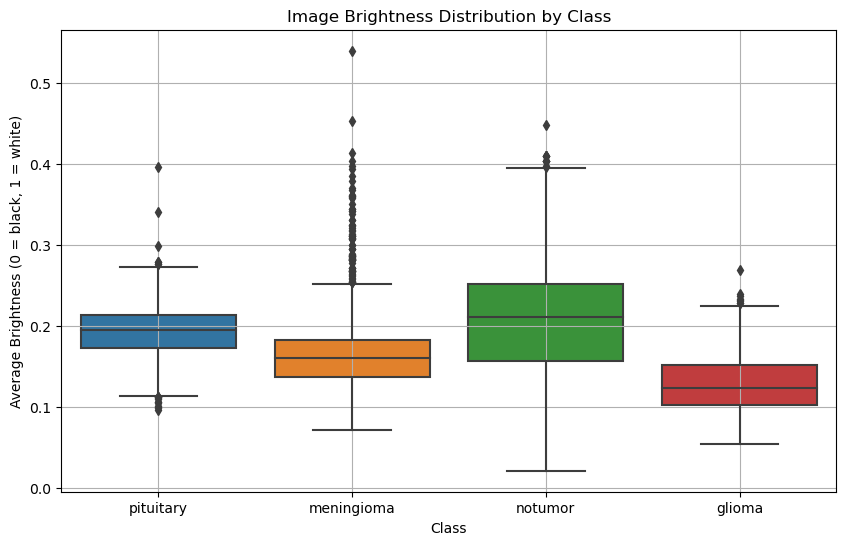

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_brightness, x="Label", y="Avg_Brightness")
plt.title("Image Brightness Distribution by Class")
plt.ylabel("Average Brightness (0 = black, 1 = white)")
plt.xlabel("Class")
plt.grid(True)
plt.show()


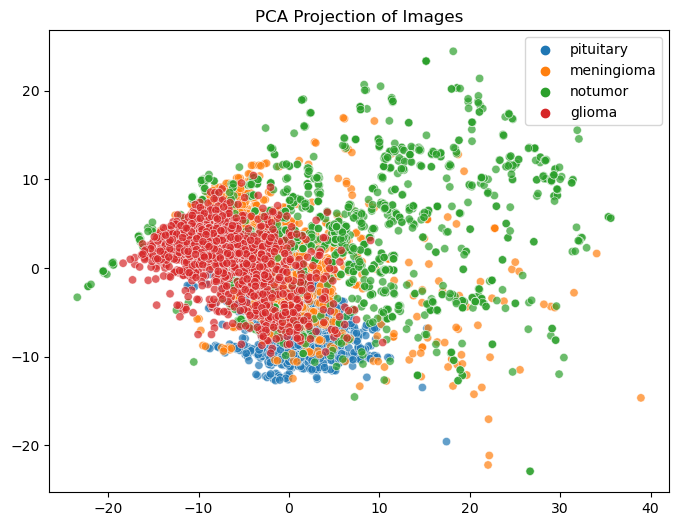

In [39]:
from sklearn.decomposition import PCA

X_flat = X_train.reshape(len(X_train), -1)
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X_flat)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=Y_train, alpha=0.7)
plt.title("PCA Projection of Images")
plt.show()


/tmp/ipykernel_3187/2989402197.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


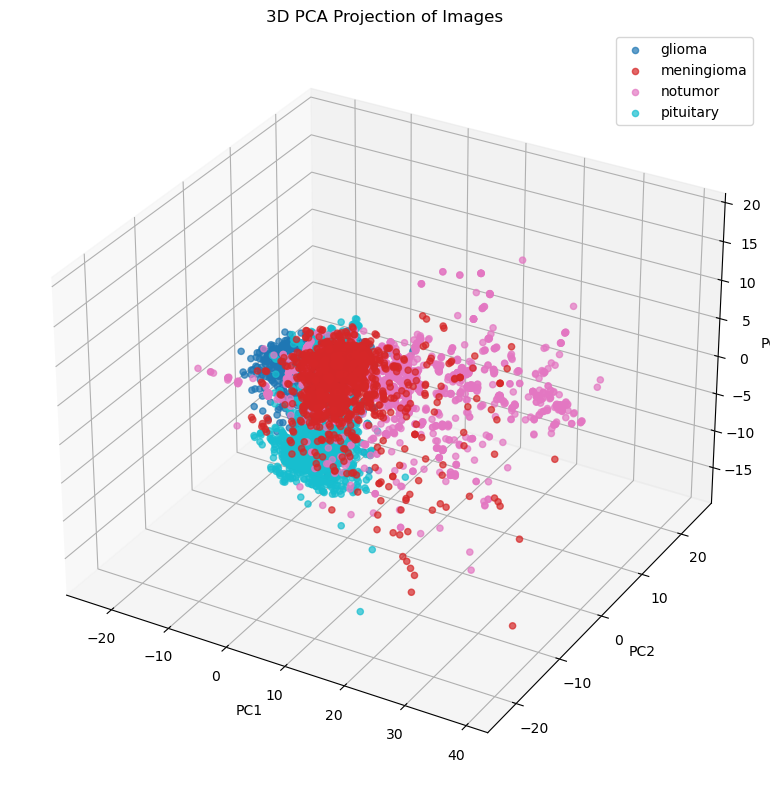

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X_flat = X_train.reshape(len(X_train), -1)

# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_flat)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assign colors per label
unique_labels = np.unique(Y_train)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    idxs = np.where(Y_train == label)
    ax.scatter(X_pca_3d[idxs, 0], X_pca_3d[idxs, 1], X_pca_3d[idxs, 2],
               label=label, alpha=0.7, color=colors(i))

ax.set_title("3D PCA Projection of Images")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()
